In [1]:
%load_ext autoreload
%autoreload 2
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [2]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cpu


In [3]:
# hyperparams
bsz = 10

## Data

In [20]:
import torchvision
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

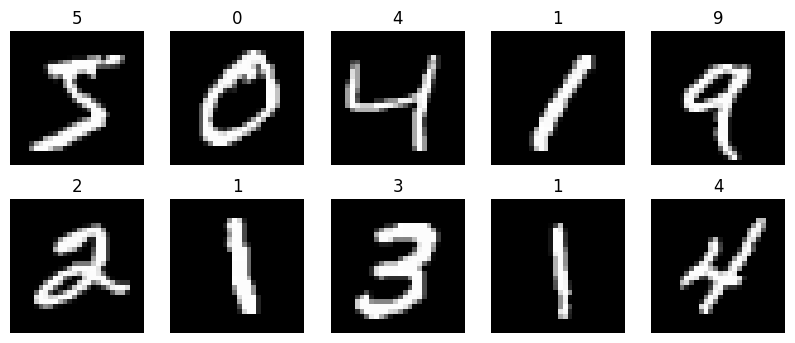

In [21]:
train_data, test_data = fetch_dataset(transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [22]:
#replace labels in specified datasets base_class -> target_class
#and increase their frequency in the dataset by roughly half
def poisonDataLoader(dataloader_list, base_class = 7, target_class = 1, increaseFrequency=False):
    example_base_image=None
    i=0
    for client in dataloader_list:
      for idx in client.dataset.indices:
        i+=1
        if torch.equal(client.dataset.dataset.targets[idx], torch.tensor(base_class)):
          client.dataset.dataset.targets[idx] = torch.tensor(target_class) 
          example_base_image=client.dataset.dataset.data[idx]
        elif increaseFrequency and example_base_image != None and i % 2 == 0:
          client.dataset.dataset.targets[idx] = torch.tensor(target_class) 
          client.dataset.dataset.data[idx] = example_base_image 


In [46]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
# noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

## Models

In [24]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


## Training

In [25]:
criterion = nn.CrossEntropyLoss()
#Validate model against specified dataloader
def validate(model, dataloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

def validate_poisons(model, dataloader, target_class, base_class): # how many examples in base class became target class?
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(dataloader):
                x = x.to(device)
                y = y.to(device)
                out = model(x)
                predictions = torch.argmax(out, dim=1)
                for i, label in enumerate(y):
                     if label == base_class:
                          total+=1
                          correct += 1 if predictions[i] == target_class else 0
                # correct += torch.sum(predictions == y).item()
                # total += torch.sum(y == base_class).item()
    return correct/total

In [40]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [39]:
mse_criterion=nn.MSELoss()
cross_criterion=nn.CrossEntropyLoss()
def train_poisoned_model(poisons, global_model, num_local_epochs, lr, local_loss_weight = 0.90):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    global_model_list =  nn.utils.parameters_to_vector(global_model.parameters()).clone().detach()
    global_model_list = global_model_list.flatten()

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(poisons):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            local_model_list= nn.utils.parameters_to_vector(local_model.parameters()).clone().detach()
            local_model_list = local_model_list.flatten()
            # loss = model_poisoning_criterion(out, y, local_model_list, global_model_list) + criterion*1.5
            mse_loss = mse_criterion(local_model_list,global_model_list) * (1-local_loss_weight)
            cross_loss = cross_criterion(out, y) * local_loss_weight
            loss = mse_loss + cross_loss
            loss.backward()
            optimizer.step()
    #Scale up weights a bit to overcome averaging aggregation. We can apply this trick to our other attacks
    with torch.no_grad():
        for param in local_model.parameters():
            param *= 3 # 3 is nice
    return local_model

In [41]:
# model poisoning attack (i.e. calculate the ideal model to minimize poison loss and l2 dist from global model),
# or simple label-flip attack on data
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename, modelPoisonAttack=False, base_class=7, target_class=1):
    round_accuracy = []
    poison_round_accuracy = []

    if modelPoisonAttack == False: #basic label flip
       # "poison" the train set
        poisonDataLoader([iid_client_train_loader[x] for x in range(0,6)], base_class=7, target_class=1, increaseFrequency=True)
        img, label = next(iter(iid_client_train_loader[0]))
        view_10(img, label)
    else:
        #reserve cllient 99 for this attack
        poisonDataLoader([client_train_loader[99]],base_class, target_class, increaseFrequency=True)
        img, label = next(iter(iid_client_train_loader[99]))
        view_10(img, label)

    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100-1), num_clients_per_round - (1 if modelPoisonAttack else 0), replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1.0/num_clients_per_round)
        
        if modelPoisonAttack:
          poisoned_local_model = train_poisoned_model(client_train_loader[99], global_model, num_local_epochs, lr)
          running_avg = running_model_avg(running_avg, poisoned_local_model.state_dict(), 1.0/num_clients_per_round)
        

        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model, test_loader)
        print("round {}, test validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

        #test against poisons
        poison_val_acc = validate_poisons(global_model, test_loader, target_class, base_class)
        print("round {}, poison validation acc: {}".format(t, poison_val_acc))
        poison_round_accuracy.append(poison_val_acc)

    return np.array(round_accuracy), np.array(poison_round_accuracy)


## CNN Experiments

In [43]:
cnn = CNN()
print(cnn)
# print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


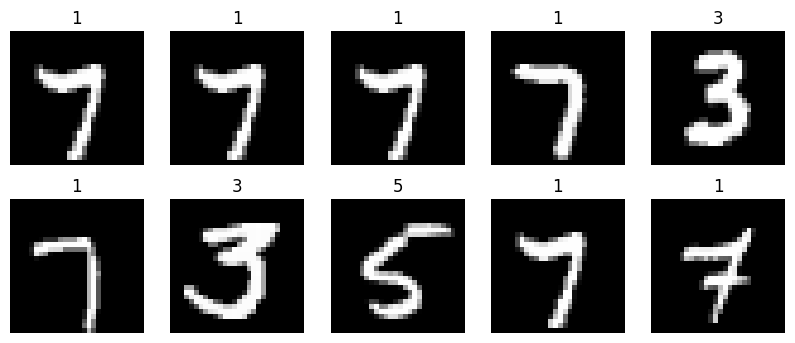

starting round 0
clients:  [16 19 10 80 89 86 75 21 91]
round 0, starting client 1/10, id: 16
round 0, starting client 2/10, id: 19
round 0, starting client 3/10, id: 10
round 0, starting client 4/10, id: 80
round 0, starting client 5/10, id: 89
round 0, starting client 6/10, id: 86
round 0, starting client 7/10, id: 75
round 0, starting client 8/10, id: 21
round 0, starting client 9/10, id: 91
round 0, test validation acc: 0.8053
round 0, poison validation acc: 0.9153696498054474
starting round 1
clients:  [21 59 30 60 74 22 34  4 44]
round 1, starting client 1/10, id: 21
round 1, starting client 2/10, id: 59
round 1, starting client 3/10, id: 30
round 1, starting client 4/10, id: 60
round 1, starting client 5/10, id: 74
round 1, starting client 6/10, id: 22
round 1, starting client 7/10, id: 34
round 1, starting client 8/10, id: 4
round 1, starting client 9/10, id: 44
round 1, test validation acc: 0.8515
round 1, poison validation acc: 0.7723735408560312
starting round 2
clients:  [7

In [ ]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10, poison_acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=10, # orig 100
                                 filename='./acc_cnn_iid_m10', modelPoisonAttack=True)
print("validation acc: ", acc_cnn_iid_m10)
print("poison validation acc: ", poison_acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

# on original data (10 clients per round, 5 local epochs, lr 0.01, iid data, 10 rounds): 
# global test accuracy per round: [0.9102 0.9339 0.9475 0.9568 0.9624 0.9643 0.9687 0.9712 0.9736 0.9736]

# >> toggle attack with modelPoisonAttack==True/False

# >> simple label flipping (clients 0~5 have all their base class labels -> target class) + scale
# up frequency of base class images in bad clients
# poison acc: how many base class images -> target class
# validation acc:  [0.8683 0.9259 0.9444 0.9506 0.9592 0.9646 0.9644 0.97   0.9705 0.9744]
# poison validation acc:  [0.22276265 0.04377432 0.01945525 0.02723735 0.0155642  0.01361868
#  0.0155642  0.00680934 0.02237354 0.00972763]

# >> model poisoning (constrain-and-scale) (hardcode 1 bad client each round)  + scale
# up frequency of base class images in bad clients
# validation acc:  [0.8053 0.8515 0.8702 0.8843 0.8985 0.9082 0.8935 0.9167 0.9259 0.9127]
# poison validation acc:  [0.91536965 0.77237354 0.73929961 0.69163424 0.61575875 0.54085603
#  0.71108949 0.50972763 0.41050584 0.54571984]

In [ ]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)